In [608]:
%pylab inline
import scipy as sp
from numba import jit

Populating the interactive namespace from numpy and matplotlib


In [609]:
@jit
def nrmse(output,target):
    combinedVar = 0.5 * (np.var(target, ddof=1) + np.var(output, ddof=1))
    errorSignal = output - target
    return np.sqrt(np.mean(errorSignal ** 2) / combinedVar)

In [610]:
def generateInternalWeights(nInternalUnits, connectivity):
    success = False
    internalWeights = 0
    while success == False:
        try:
            internalWeights = np.random.randn(nInternalUnits,nInternalUnits) * (np.random.random((nInternalUnits,nInternalUnits)) < connectivity)
            specRad = abs(np.linalg.eig(internalWeights)[0][0])
            if (specRad > 0):
                internalWeights = internalWeights / specRad
                success = True
        except e:
            print(e)
    return internalWeights

/Volumes/LocalDataHD/virtualenvs/env3/chrysalisConceptors


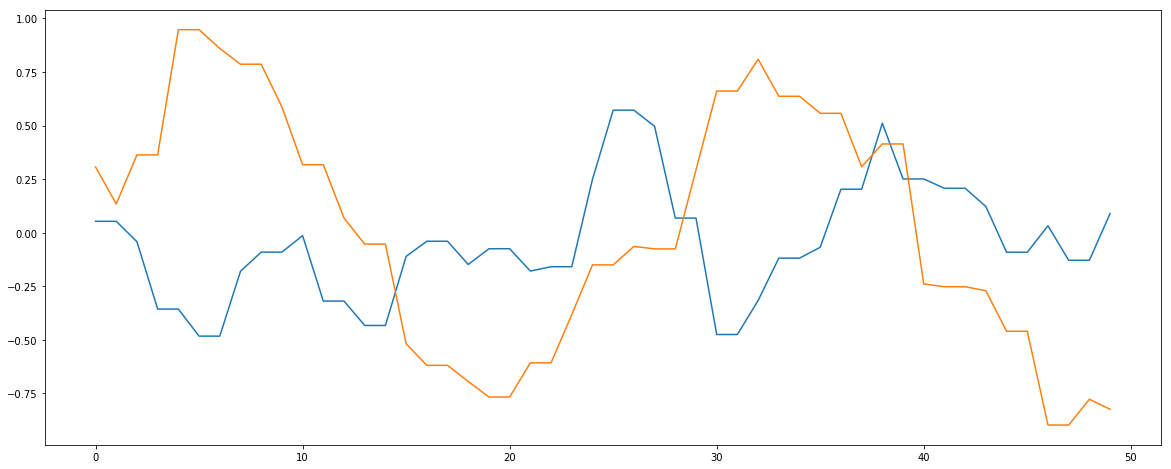

In [685]:
import os
# get current working path
cwd = os.getcwd()
print( cwd )

# load gesture 1
# gesture1 = np.loadtxt(cwd + '/workshop/gesturedata_0.txt')
# gesture2 = np.loadtxt(cwd + '/workshop/gesturedata_1.txt')
gesture1 = np.loadtxt(cwd + '/supercollider/gesturedata_1_1.txt')
gesture2 = np.loadtxt(cwd + '/supercollider/gesturedata_5_1.txt')

# plot the two gestures
figsize(20,8);
gesture1 = (gesture1 * 250) 
gesture2 = (gesture2 * 250) 

plot( gesture1)
plot( gesture2)


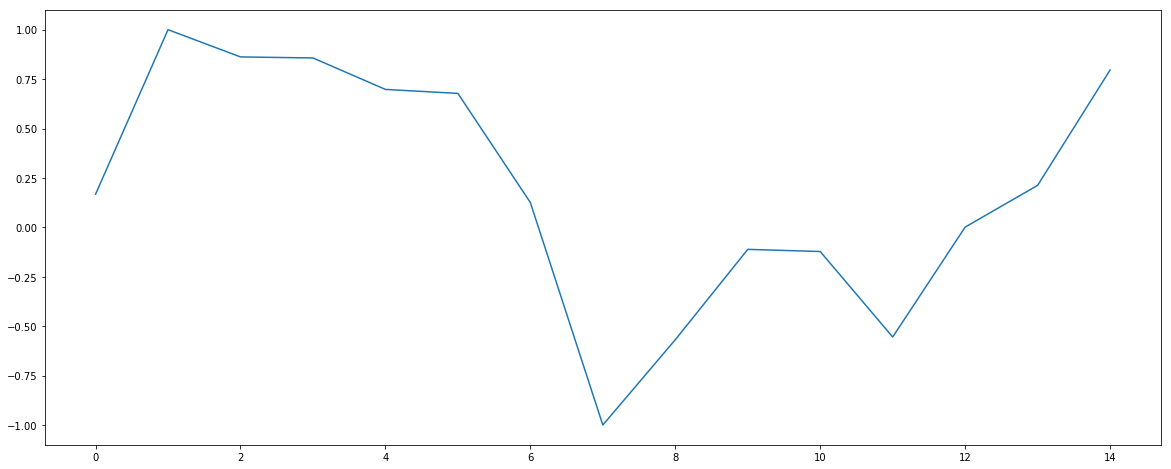

In [612]:
#plot(np.tanh(np.random.randn(10)))
def makeRandomWalk(len):
    pt = zeros(len)
    pt[0] = np.random.randn(1)
    for n in range(pt.size-1):
        pt[n+1] = pt[n] + np.random.randn(1)
    pt = pt - np.min(pt)
    pt = (pt / np.max(pt) * 2) - 1
    return pt
    

#plot()
plot(makeRandomWalk(15))

[ 0.88815568  0.27766825]


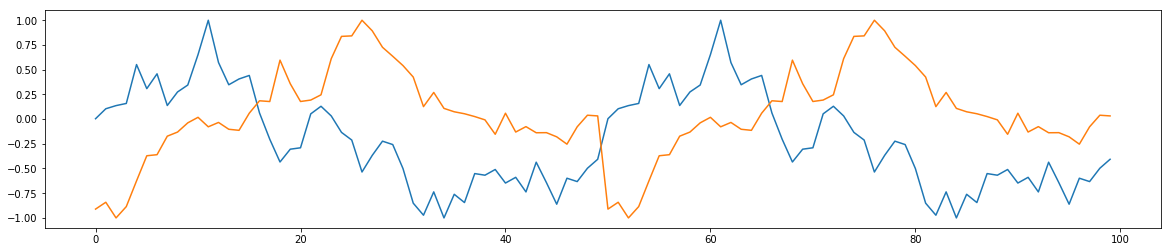

In [53]:
figsize(20,4)
# pSaw = lambda n: (round(n % waveLengthSamples) / waveLengthSamples * 2) - 1.0
# plot([pSaw(x) for x in arange(300)])
# pPulse = lambda n: (((n % waveLengthSamples) < (waveLengthSamples * 0.5)) * 2) - 1.0
# plot([pPulse(x) for x in arange(300)])
# pSine2 = lambda n: (sin(n) * sin((n+pi/4)/6))
# plot([pSine2(x) for x in arange(100)])
# pSine3 = lambda n: (sin(n) * sin((n/4)/6)/6)
# plot([pSine3(x) for x in arange(100)])

pJ1 = lambda n: 1 * sin(2 * pi * n / 3.1504531)
# plot([pJ1(x) for x in arange(100)])
pJ1b = lambda n, d: 1 * sin(n/d) ** 1
# plot([pJ1b(x,2) for x in arange(100)])

period2 = 2
rawp = np.random.randn(period2)
# rawp = np.array([1.1929,2.6856]);
maxVal = np.max(rawp)
minVal = np.min(rawp)
print(rawp)
rp = 0.5 * (2 * (rawp - minVal) / (maxVal - minVal) - 1);
pJ2 = lambda n: rp[mod(n, period2 )]
# plot([pJ2(x) for x in arange(100)])

#pTri = lambda n,p: (n % (p/2)) * ((n % p) > 0.5)
# pTri = lambda n,p: ((((n % p) >= (p/2)) * ((p/2) - (n % (p/2))) + ((n % p) < (p/2)) * (n % (p/2))) * (2/p)) * 2 -1
# #pTri = lambda n,p: (n % (p/2))
# plot([pTri(x,10) for x in arange(100)])

patternLength = 50
p_rw1 = makeRandomWalk(patternLength)
p_rw2 = makeRandomWalk(patternLength)
pLoop = lambda n,p: p[n%p.size]
plot([pLoop(x,p_rw1) for x in arange(100)])
plot([pLoop(x,p_rw2) for x in arange(100)])


In [669]:

def makeClassifierNetwork(p):
    Netconnectivity = 1
    if p['N'] > 20:
        Netconnectivity = 10.0/p['N'];
    WstarRaw = generateInternalWeights(p['N'], Netconnectivity)
    WinRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)
    WbiasRaw = 2 * (np.random.rand(p['N'], 1) - 0.5)

    #Scale raw weights     
    Wstar = p['NetSR'] * WstarRaw;
    W = Wstar
    Win = p['NetinpScaling'] * WinRaw;
    Wbias = p['BiasScaling'] * WbiasRaw;  
    I = np.eye(p['N'])
    xCollector = np.zeros((p['N'], p['learnLength']))
    pCollector = np.zeros((1, p['learnLength']))
    x = np.zeros((p['N'],1))
    
    allTrainxArgs = np.zeros((p['N'] + 1, 0));
    allTrainOldxArgs = np.zeros((p['N'], 0));
    allTrainWtargets = np.zeros((p['N'], 0));
    allTrainOuts = np.zeros((1, 0));
    patternRs =  np.zeros((1, p['patts'].size), dtype=np.object)
    
    for i_pattern in range(p['patts'].size):
        print('Observing pattern ', i_pattern)
        patt = p['patts'][i_pattern]
        xCollector = np.zeros((p['N'] + 1, p['learnLength']));
        xOldCollector = np.zeros((p['N'], p['learnLength']));
        WTargetCollector = np.zeros((p['N'], p['learnLength']));
        pCollector = np.zeros((1, p['learnLength']));
        x = np.zeros((p['N'], 1));

        for n in range(p['washoutLength'] + p['learnLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (Wstar.dot(x)) + (Win.dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + Wbias))
            if n >= p['washoutLength']:
                xCollector[:, n - p['washoutLength']] = np.concatenate((x[:,0], np.array([1])))
                xOldCollector[:, n - p['washoutLength']] = xOld[:,0]
                WTargetCollector[:, n - p['washoutLength']] = Wtarget[:,0]
                pCollector[0, n - p['washoutLength']] = u
            uOld = u
        
        R = xCollector[0:-1].dot(xCollector[0:-1].T) / p['learnLength']
        patternRs[0,i_pattern] = R
        allTrainxArgs = np.concatenate((allTrainxArgs, xCollector), axis=1)
        allTrainOldxArgs = np.concatenate((allTrainOldxArgs, xOldCollector), axis=1)
        allTrainOuts = np.concatenate((allTrainOuts, pCollector), axis=1)
        allTrainWtargets = np.concatenate((allTrainWtargets, WTargetCollector), axis=1)

    return locals()

params = {'N':50, 'NetSR':1.3, 'NetinpScaling':2,'BiasScaling':0.9,
         'washoutLength':90, 'learnLength':60, 
          'LR': 0.6,
#           'patts':np.array([lambda x:pLoop(x,p_rw1), lambda x: pLoop(x,p_rw2)])
          'patts':np.array([lambda x:pLoop(x,gesture1), lambda x: pLoop(x,gesture2)])
         }

net = makeClassifierNetwork(params)


Observing pattern  0
Observing pattern  1


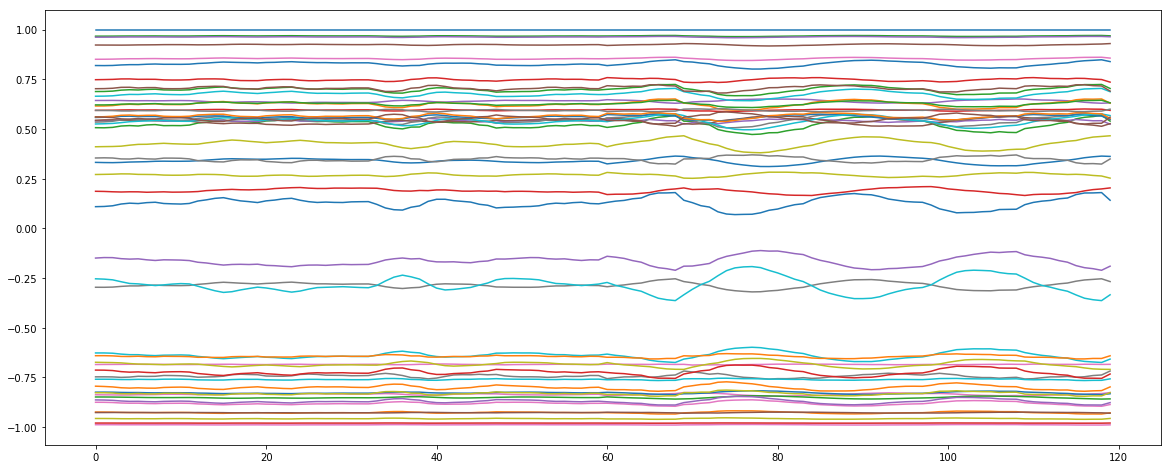

In [670]:
figsize(20,8)
plot(net['allTrainxArgs'].T)
None

In [648]:

def computeConceptors(p, net, alphas):
    print('Computing conceptors, alphas: ', alphas)
    Cs = np.zeros((4, p['patts'].size), dtype=np.object)
    for i_pattern in range(p['patts'].size):
        R = net['patternRs'][0,i_pattern]
        [U,s,V] = svd(R)
        S = diag(s)
        Snew = (S * linalg.inv(S + pow(alphas[i_pattern], -2) * np.eye(p['N'])))

        C =  U.dot(Snew).dot(U.T);
        Cs[0,i_pattern] = C
        Cs[1,i_pattern] = U
        Cs[2,i_pattern] = diag(Snew)
        Cs[3,i_pattern] = diag(S)
    return locals()

cnet = computeConceptors(params, net, np.array([10,20.0]))

Computing conceptors, alphas:  [ 10.  20.]


In [666]:
import scipy.spatial.distance as dist


def plotConceptorPatterns(p, cNet, subr, suboff, recallTestLength):
    x_CTestPL = np.zeros((3, recallTestLength, p['patts'].size))
    p_CTestPL = np.zeros((1, recallTestLength, p['patts'].size))
    cx_CTestPL = np.zeros((p['patts'].size,recallTestLength))
    pat_CTestPL = np.zeros((1,recallTestLength))
    
    for i_pattern in range(p['patts'].size):
        patt = p['patts'][i_pattern]
        x = np.zeros((p['N'],1))
        for n in range(recallTestLength + p['washoutLength']):
            u = patt(n+1)
            xOld = x
            Wtarget = (cNet['net']['W'].dot(x)) + (cNet['net']['Win'].dot(u))
            x = ((1.0-p['LR']) * xOld) + (p['LR'] * tanh(Wtarget + cNet['net']['Wbias']))
            if (n > p['washoutLength']):
                pat_CTestPL[0,n-p['washoutLength'] ] = u
                C = cNet['Cs'][0,0]
                C2 = cNet['Cs'][0,1]
                cx = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
                cx_CTestPL[0,n-p['washoutLength']] = cx
                cx2 = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
#                 cx2 = x.T.dot(C2.dot(x))
                cx_CTestPL[1,n-p['washoutLength']] = cx2
#                 cxNeither = x.T.dot((1.0 - C2).dot(x)) + x.T.dot((1.0-C).dot(x))
#                 cx_CTestPL[2,n-p['washoutLength']] = cxNeither

        ax = subplot(subr, 2, suboff + i_pattern + 1)
        ax.set_title("Sample " + str(suboff/2) + ", pattern: " + str(i_pattern) + ", alphas: " + str(cNet['alphas']))
#         plot([p['patts'][i_pattern](x) for x in arange(recallTestLength)])
        plot(pat_CTestPL.T)
        plot(cx_CTestPL.T)
        classificationScore = np.sum(cx_CTestPL[i_pattern] > cx_CTestPL[1 - i_pattern]) / cx_CTestPL[0].size
        separation = dist.euclidean(cx_CTestPL[i_pattern],cx_CTestPL[1-i_pattern])
        print("Pattern ", str(i_pattern), " classification score: ", classificationScore, ", separation: ", separation)
        #testing

    return locals()


Computing conceptors, alphas:  [ 33.82210996  17.16627804]
Pattern  0  classification score:  0.99 , separation:  54.55761321935134
Pattern  1  classification score:  0.99 , separation:  37.13741861657896
Computing conceptors, alphas:  [ 73.56423146  66.64942062]
Pattern  0  classification score:  0.99 , separation:  24.911465506042124
Pattern  1  classification score:  0.99 , separation:  31.70427541652536
Computing conceptors, alphas:  [ 17.42781268  77.74122672]
Pattern  0  classification score:  0.99 , separation:  23.557130875065322
Pattern  1  classification score:  0.99 , separation:  47.14788347610616
Computing conceptors, alphas:  [  8.77311659  24.68959345]
Pattern  0  classification score:  0.99 , separation:  40.39171113711716
Pattern  1  classification score:  0.99 , separation:  64.56515037693326
Computing conceptors, alphas:  [ 21.2191504   36.11315979]
Pattern  0  classification score:  0.99 , separation:  32.13324854337102
Pattern  1  classification score:  0.99 , sepa

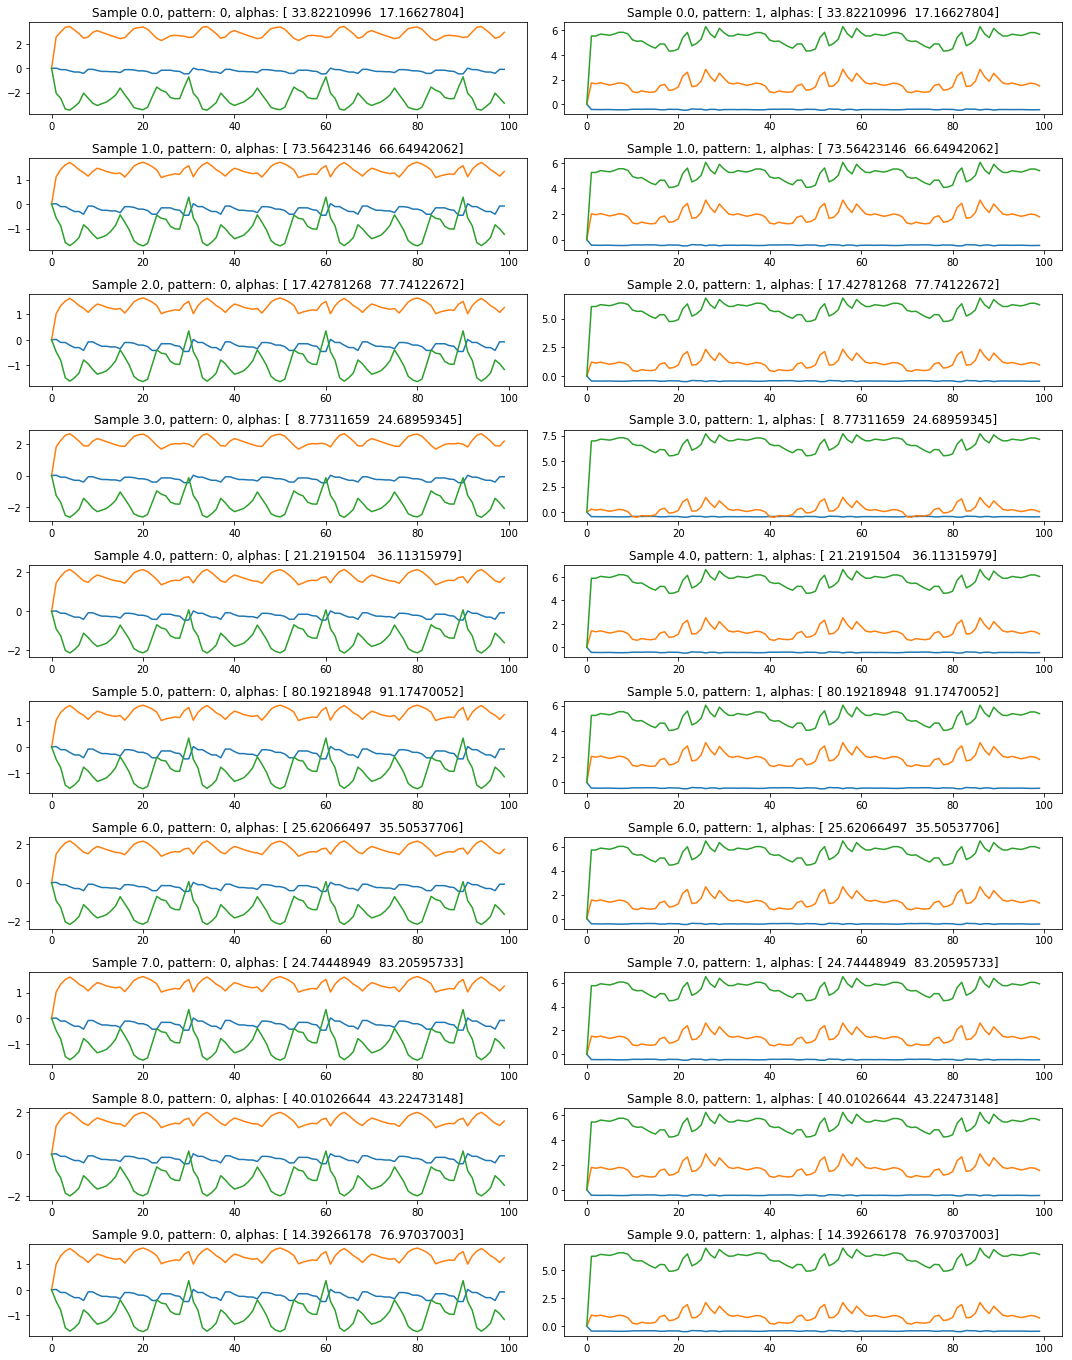

In [667]:
conceptorSampleSize = 10
conceptorNets = np.zeros(conceptorSampleSize, dtype=np.object)
figsize(15,conceptorSampleSize * 1.9)
for i_cnet in range(conceptorSampleSize):
    conceptorNets[i_cnet] = computeConceptors(params, net, np.random.random(2) * 100)
    pq = plotConceptorPatterns(params, conceptorNets[i_cnet], conceptorSampleSize, i_cnet * 2, 100)
plt.tight_layout();


Pattern  0  classification score:  0.99 , separation:  120.47303716666993
Pattern  1  classification score:  0.99 , separation:  31.903980052359664


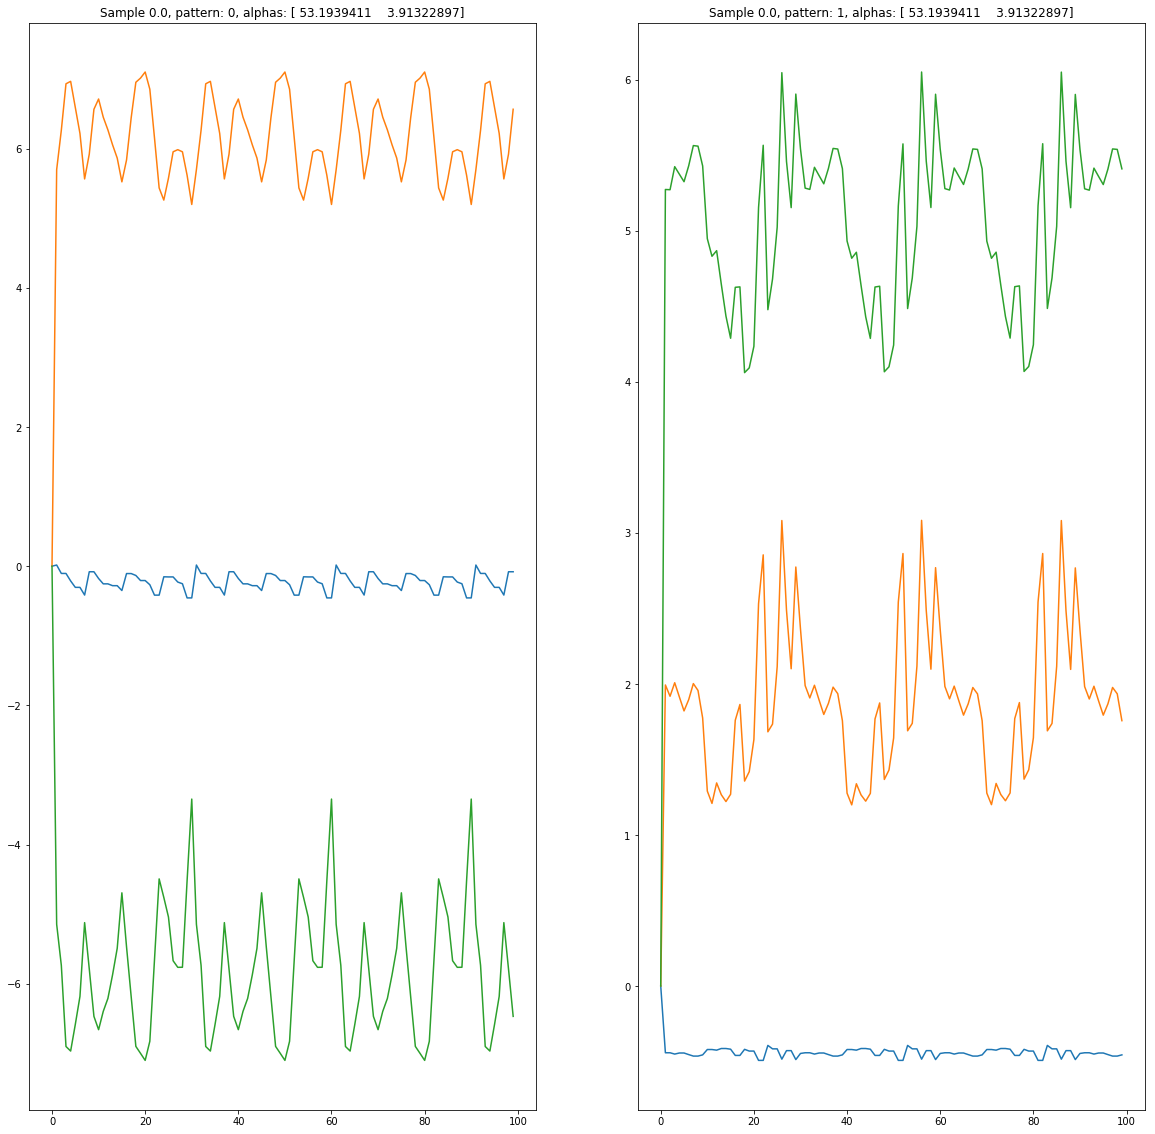

In [657]:
figsize(20,20)
plotConceptorPatterns(params, conceptorNets[3], 1, 0, 100)
None

In [486]:
a = np.ones(100) * 30
# a[5] = 0
b = np.ones(100) * 2

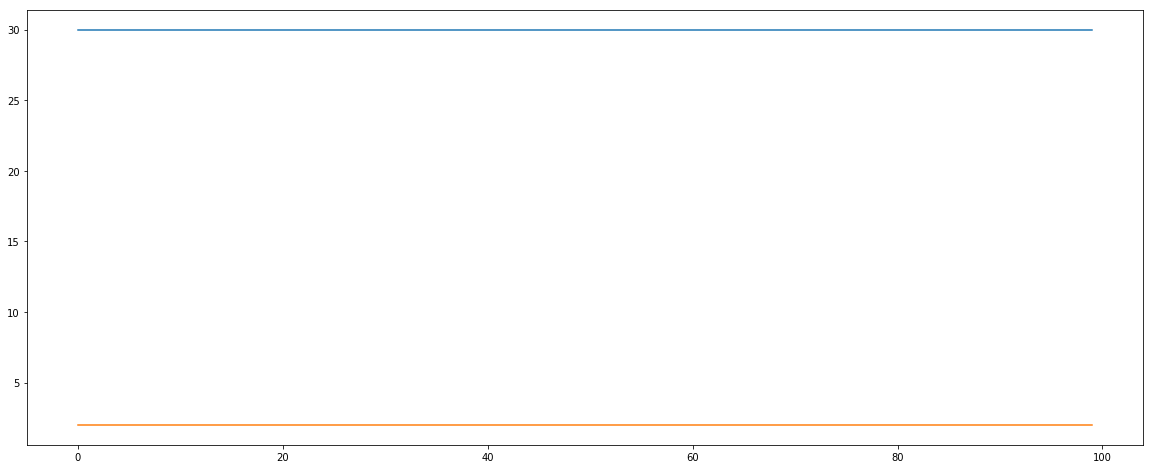

In [487]:
plot(a)
plot(b)

In [488]:
np.sum(a > b) / a.size

1.0

In [656]:
import dill as pickle
with open(r"workshop/net.pickle", "wb") as output_file:
    pickle.dump(conceptorNets[3], output_file, protocol=0)

In [36]:
serialised  = pickle.dumps(conceptorNets[0], protocol=0) 

In [38]:
restored = pickle.loads(serialised)

In [569]:
@jit
def iterateClassifier(net, state, u):
    state['xOld'] = state['x']
    Wtarget = (net['net']['W'].dot(state['x'])) + (net['net']['Win'].dot(u))
    state['x'] = ((1.0-net['p']['LR']) * state['xOld']) + (net['p']['LR'] * tanh(Wtarget + net['net']['Wbias']))
    C = net['Cs'][0,0]
    C2 = net['Cs'][0,1]
    x = state['x']

    state['evidence'][0] = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
    state['evidence'][1] = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
    return state

In [570]:
state = createState(restored)

In [604]:
%%time
state = iterateClassifier(restored, state, 0.3)
# state['evidence']

CPU times: user 674 µs, sys: 637 µs, total: 1.31 ms
Wall time: 719 µs


In [237]:
with open(r"/tmp/net.pickle", "rb") as input_file:
    restored = pickle.load(input_file)

In [238]:
restored

{'C': array([[ 0.02127242,  0.02201485,  0.00347284, ..., -0.00400831,
         -0.00270888,  0.00365605],
        [ 0.02201485,  0.0234903 ,  0.00520533, ..., -0.00461021,
         -0.00238164,  0.00676053],
        [ 0.00347284,  0.00520533,  0.0625042 , ...,  0.01679136,
         -0.03263176, -0.00787368],
        ..., 
        [-0.00400831, -0.00461021,  0.01679136, ...,  0.00712324,
         -0.01120593, -0.00844082],
        [-0.00270888, -0.00238164, -0.03263176, ..., -0.01120593,
          0.0431258 ,  0.0360839 ],
        [ 0.00365605,  0.00676053, -0.00787368, ..., -0.00844082,
          0.0360839 ,  0.046371  ]]),
 'Cs': array([[ array([[ 0.02236148,  0.02060132,  0.00109564, ..., -0.00304707,
         -0.00285648,  0.00102892],
        [ 0.02060132,  0.02246432,  0.00497084, ..., -0.00327726,
         -0.00208295,  0.00755698],
        [ 0.00109564,  0.00497084,  0.06647975, ...,  0.01677782,
         -0.02968648, -0.00188284],
        ..., 
        [-0.00304707, -0.0032772

In [252]:
def createState(net):
    return {'x':np.zeros((net['p']['N'],1)),
           'xOld':np.zeros((net['p']['N'],1)),
           'evidence':np.zeros(2)}

def iterateClassifier(net, state, u):
    state['xOld'] = state['x']
    Wtarget = (net['net']['W'].dot(state['x'])) + (net['net']['Win'].dot(u))
    state['x'] = ((1.0-net['p']['LR']) * state['xOld']) + (net['p']['LR'] * tanh(Wtarget + net['net']['Wbias']))
    C = net['Cs'][0,0]
    C2 = net['Cs'][0,1]
    x = state['x']

    state['evidence'][0] = x.T.dot(C.dot(x)) + x.T.dot((1.0-C2).dot(x))
    state['evidence'][1] = x.T.dot(C2.dot(x)) + x.T.dot((1.0-C).dot(x))
    return state
    

In [253]:
state = createState(restored)
state = iterateClassifier(restored, state, 0.4)
state['evidence']

array([ 0.02834556, -0.01893342])

In [523]:
state = iterateClassifier(restored, state, 0.4)
state['evidence']

array([ 15.64755688,  14.06207755])

In [255]:
np.zeros(restored['p']['N']) 

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [665]:
str(datetime.datetime.timestamp(datetime.datetime.now()))

'1505234168.716125'